# Testing
### Wochenaufenthalter/-innen in der Stadt Zürich, nach Altersklasse, Herkunft, Stadtquartier, Stadtkreis, Zuzugskanton und Zuzugsbezirk, seit 1993
Datum: 11.01.2022

Mit Colab kann **dieses Jupyter-Notebook interaktiv im Browser** gestartet werden:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DonGoginho/myPy/blob/main/plausis/plausi_bev_jahresupdates/od3582_bev_bestand_woauha_jahr_quartier_herk_ag_zzgsgebiet_OD3582.ipynb)



### Importiere die notwendigen Packages

In [34]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [35]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

import requests
import io

import plotly.express as px


In [36]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [37]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [38]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [39]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [40]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 3 datenstand:  1 time.struct_time(tm_year=2022, tm_mon=3, tm_mday=17, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=76, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [41]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [42]:
package_name = "bev_bestand_woauha_jahr_quartier_herk_ag_zzgsgebiet_od3582"

In [43]:
dataset_name = "BEV358OD3582.csv"

**Statische Pfade in DWH-Dropzones**

In [44]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [45]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [46]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [47]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [48]:
from IPython.display import Markdown as md

In [49]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_woauha_jahr_quartier_herk_ag_zzgsgebiet_od3582 

In [50]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev_bestand_woauha_jahr_quartier_herk_ag_zzgsgebiet_od3582 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [51]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

integ - web


In [52]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_woauha_jahr_quartier_herk_ag_zzgsgebiet_od3582/download/BEV358OD3582.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [53]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['StichtagDatJahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


StichtagDatJahr      datetime64[ns]
AlterV10Cd                    int64
AlterV10Lang                 object
HerkunftCd                    int64
HerkunftLang                 object
KreisCd                       int64
KreisLang                    object
QuarCd                        int64
QuarLang                     object
ZuzKtHistCd                   int64
ZuzKtHistLang                object
ZuzBezirkHistCd               int64
ZuzBezirkHistLang            object
AnzBestWir                    int64
dtype: object

Berechne weitere Attribute falls notwendig

In [54]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr_str = lambda x: x.StichtagDatJahr.astype(str),
    )
    .sort_values('StichtagDatJahr', ascending=False)
    )
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
AlterV10Cd                      int64
AlterV10Lang                   object
HerkunftCd                      int64
HerkunftLang                   object
KreisCd                         int64
KreisLang                      object
QuarCd                          int64
QuarLang                       object
ZuzKtHistCd                     int64
ZuzKtHistLang                  object
ZuzBezirkHistCd                 int64
ZuzBezirkHistLang              object
AnzBestWir                      int64
StichtagDatJahr_str            object
dtype: object

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [55]:
#data2betested.head(6)

In [56]:
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
AlterV10Cd                      int64
AlterV10Lang                   object
HerkunftCd                      int64
HerkunftLang                   object
KreisCd                         int64
KreisLang                      object
QuarCd                          int64
QuarLang                       object
ZuzKtHistCd                     int64
ZuzKtHistLang                  object
ZuzBezirkHistCd                 int64
ZuzBezirkHistLang              object
AnzBestWir                      int64
StichtagDatJahr_str            object
dtype: object

In [57]:
data2betested.shape

(193700, 15)

Beschreibe einzelne Attribute

In [58]:
data2betested.describe()

,AlterV10Cd,HerkunftCd,KreisCd,QuarCd,ZuzKtHistCd,ZuzBezirkHistCd,AnzBestWir
count,193700,193700,193700,193700,193700,193700,193700
mean,27,1,7,70,14,1445,2
std,13,0,3,34,15,1478,4
min,0,1,1,11,1,101,1
25%,20,1,4,42,3,305,1
50%,20,1,7,72,17,1702,1
75%,30,1,10,101,19,1909,2
max,100,2,12,123,99,9999,107


Wie viele Nullwerte gibt es im Datensatz?

In [59]:
data2betested.isnull().sum()

StichtagDatJahr        0
AlterV10Cd             0
AlterV10Lang           0
HerkunftCd             0
HerkunftLang           0
KreisCd                0
KreisLang              0
QuarCd                 0
QuarLang               0
ZuzKtHistCd            0
ZuzKtHistLang          0
ZuzBezirkHistCd        0
ZuzBezirkHistLang      0
AnzBestWir             0
StichtagDatJahr_str    0
dtype: int64

Welches sind die Quartiere ohne Werte bei AnzBestWir?

In [60]:
data2betested[np.isnan(data2betested.AnzBestWir)]

,StichtagDatJahr,AlterV10Cd,AlterV10Lang,HerkunftCd,HerkunftLang,KreisCd,KreisLang,QuarCd,QuarLang,ZuzKtHistCd,ZuzKtHistLang,ZuzBezirkHistCd,ZuzBezirkHistLang,AnzBestWir,StichtagDatJahr_str


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [61]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [62]:
data2betested.info()
data2betested.index.year.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 193700 entries, 2021-01-01 to 1993-01-01
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   AlterV10Cd           193700 non-null  int64 
 1   AlterV10Lang         193700 non-null  object
 2   HerkunftCd           193700 non-null  int64 
 3   HerkunftLang         193700 non-null  object
 4   KreisCd              193700 non-null  int64 
 5   KreisLang            193700 non-null  object
 6   QuarCd               193700 non-null  int64 
 7   QuarLang             193700 non-null  object
 8   ZuzKtHistCd          193700 non-null  int64 
 9   ZuzKtHistLang        193700 non-null  object
 10  ZuzBezirkHistCd      193700 non-null  int64 
 11  ZuzBezirkHistLang    193700 non-null  object
 12  AnzBestWir           193700 non-null  int64 
 13  StichtagDatJahr_str  193700 non-null  object
dtypes: int64(7), object(7)
memory usage: 22.2+ MB


Int64Index([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008,
            2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994,
            1993],
           dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [63]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [70]:
data2betested.loc["2021"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,AlterV10Cd,AlterV10Lang,HerkunftCd,HerkunftLang,KreisCd,KreisLang,QuarCd,QuarLang,ZuzKtHistCd,ZuzKtHistLang,ZuzBezirkHistCd,ZuzBezirkHistLang,AnzBestWir,StichtagDatJahr_str
StichtagDatJahr,,,,,,,,,,,,,,
2021-01-01,100,100-Jährige und Ältere,1,Schweizer/in,2,Kreis 2,24,Enge,1,Zürich,104,Bezirk Dielsdorf,1,2021-01-01
2021-01-01,20,20- bis 29-Jährige,1,Schweizer/in,8,Kreis 8,82,Mühlebach,3,Luzern,313,Wahlkreis Hochdorf,3,2021-01-01


----------------------------------------------------------------------------------------
**Selektionen und Aggregationen**

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

In [71]:
data2betested.columns

Index(['AlterV10Cd', 'AlterV10Lang', 'HerkunftCd', 'HerkunftLang', 'KreisCd', 'KreisLang',
       'QuarCd', 'QuarLang', 'ZuzKtHistCd', 'ZuzKtHistLang', 'ZuzBezirkHistCd',
       'ZuzBezirkHistLang', 'AnzBestWir', 'StichtagDatJahr_str'],
      dtype='object')

In [76]:
altersgruppen= data2betested.loc["2021"].groupby(['StichtagDatJahr_str','AlterV10Cd', 'AlterV10Lang'])[['AnzBestWir']].sum()
altersgruppen

AnzBestWir
StichtagDatJahr_str AlterV10Cd AlterV10Lang                      
2021-01-01          0          0- bis 9-Jährige                73
                    10         10- bis 19-Jährige             600
                    20         20- bis 29-Jährige           11347
                    30         30- bis 39-Jährige            1429
                    40         40- bis 49-Jährige             604
                    50         50- bis 59-Jährige             685
                    60         60- bis 69-Jährige             324
                    70         70- bis 79-Jährige             136
                    80         80- bis 89-Jährige              99
                    90         90- bis 99-Jährige              49
                    100        100-Jährige und Ältere           1

### Visualisierungen nach Zeitausschnitten

In [78]:
#data2betested.columns

Index(['AlterV10Cd', 'AlterV10Lang', 'HerkunftCd', 'HerkunftLang', 'KreisCd', 'KreisLang',
       'QuarCd', 'QuarLang', 'ZuzKtHistCd', 'ZuzKtHistLang', 'ZuzBezirkHistCd',
       'ZuzBezirkHistLang', 'AnzBestWir', 'StichtagDatJahr_str'],
      dtype='object')

#### Entwicklung Wochenaufenthaltende nach Altersgruppe

In [82]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2008":"2021"]\
    .groupby(['StichtagDatJahr', 'AlterV10Cd', 'AlterV10Lang',]) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,AlterV10Cd,AlterV10Lang,sum_WBev
0,2008-01-01,0,0- bis 9-Jährige,46
1,2008-01-01,10,10- bis 19-Jährige,619
2,2008-01-01,20,20- bis 29-Jährige,10477


In [83]:
myTitle="Wochenaufenthaltende nach Altersgruppe, 1993-2021"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['AlterV10Lang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>3'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('AlterV10Lang', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'AlterV10Lang','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung nach Herkunft

In [151]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["1993":"2021"]\
    .groupby(['StichtagDatJahr', 'HerkunftLang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,HerkunftLang,sum_WBev
0,1993-01-01,Ausländer/in,940
1,1993-01-01,Schweizer/in,13973
2,1994-01-01,Ausländer/in,965


In [152]:
myTitle="Wochenaufenthaltende nach Herkunft, 1993-2021"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['HerkunftLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>300'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('HerkunftLang', legend=alt.Legend(title="Herkunft", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'HerkunftLang','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

In [159]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["1993":"2021"]\
    .groupby(['StichtagDatJahr', 'ZuzKtHistLang','ZuzKtHistCd']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,ZuzKtHistLang,ZuzKtHistCd,sum_WBev
0,1993-01-01,Aargau,19,976
1,1993-01-01,Zürich,1,1993
2,1993-01-01,Zug,9,277


In [166]:
myTitle="Wochenaufenthaltende nach Zuzugskanton, 1993-2021"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['ZuzKtHistLang'], nearest=True)

base = alt.Chart(myAgg.reset_index().query('sum_WBev>500'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('ZuzKtHistLang', legend=alt.Legend(title="Herkunft", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'ZuzKtHistLang','sum_WBev']    
)

points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=700 , height=500
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [153]:
data2betested.columns

Index(['AlterV10Cd', 'AlterV10Lang', 'HerkunftCd', 'HerkunftLang', 'KreisCd', 'KreisLang',
       'QuarCd', 'QuarLang', 'ZuzKtHistCd', 'ZuzKtHistLang', 'ZuzBezirkHistCd',
       'ZuzBezirkHistLang', 'AnzBestWir', 'StichtagDatJahr_str'],
      dtype='object')

In [154]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2021"]\
    .groupby(['StichtagDatJahr','AlterV10Cd', 'AlterV10Lang', 'HerkunftLang', 'HerkunftCd']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,AlterV10Cd,AlterV10Lang,HerkunftLang,HerkunftCd,sum_WBev
0,2021-01-01,0,0- bis 9-Jährige,Ausländer/in,2,23
1,2021-01-01,90,90- bis 99-Jährige,Ausländer/in,2,6
2,2021-01-01,80,80- bis 89-Jährige,Schweizer/in,1,92


In [155]:
#help(sns.catplot)     

In [ ]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

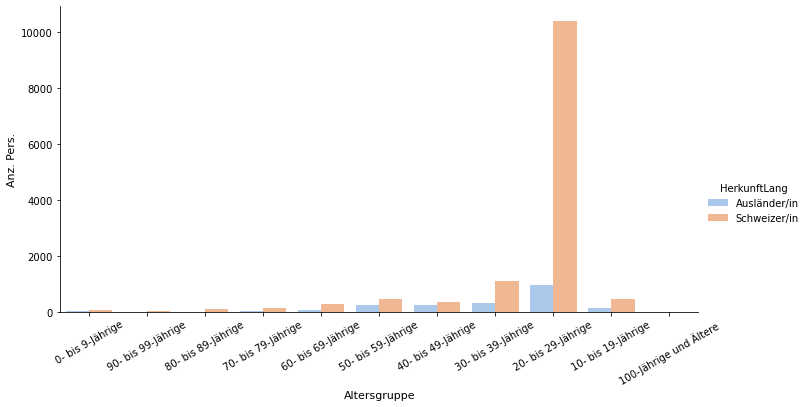

In [95]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="AlterV10Lang"
            , y="sum_WBev"
            , hue="HerkunftLang"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xticklabels(rotation=30) 
myHist.set_xlabels('Altersgruppe', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


In [97]:
#data2betested.columns

Index(['AlterV10Cd', 'AlterV10Lang', 'HerkunftCd', 'HerkunftLang', 'KreisCd', 'KreisLang',
       'QuarCd', 'QuarLang', 'ZuzKtHistCd', 'ZuzKtHistLang', 'ZuzBezirkHistCd',
       'ZuzBezirkHistLang', 'AnzBestWir', 'StichtagDatJahr_str'],
      dtype='object')

In [117]:
myAggBar = data2betested.query('HerkunftLang !="Ausland"')\
    .groupby(['StichtagDatJahr', 'QuarLang', 'QuarCd','ZuzKtHistCd', 'ZuzKtHistLang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('QuarCd', ascending=True) 

In [118]:
myAggBar2 = data2betested.query('HerkunftLang !="Ausland"')\
    .groupby(['StichtagDatJahr', 'AlterV10Cd', 'AlterV10Lang','QuarLang', 'QuarCd']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('QuarCd', ascending=True) 

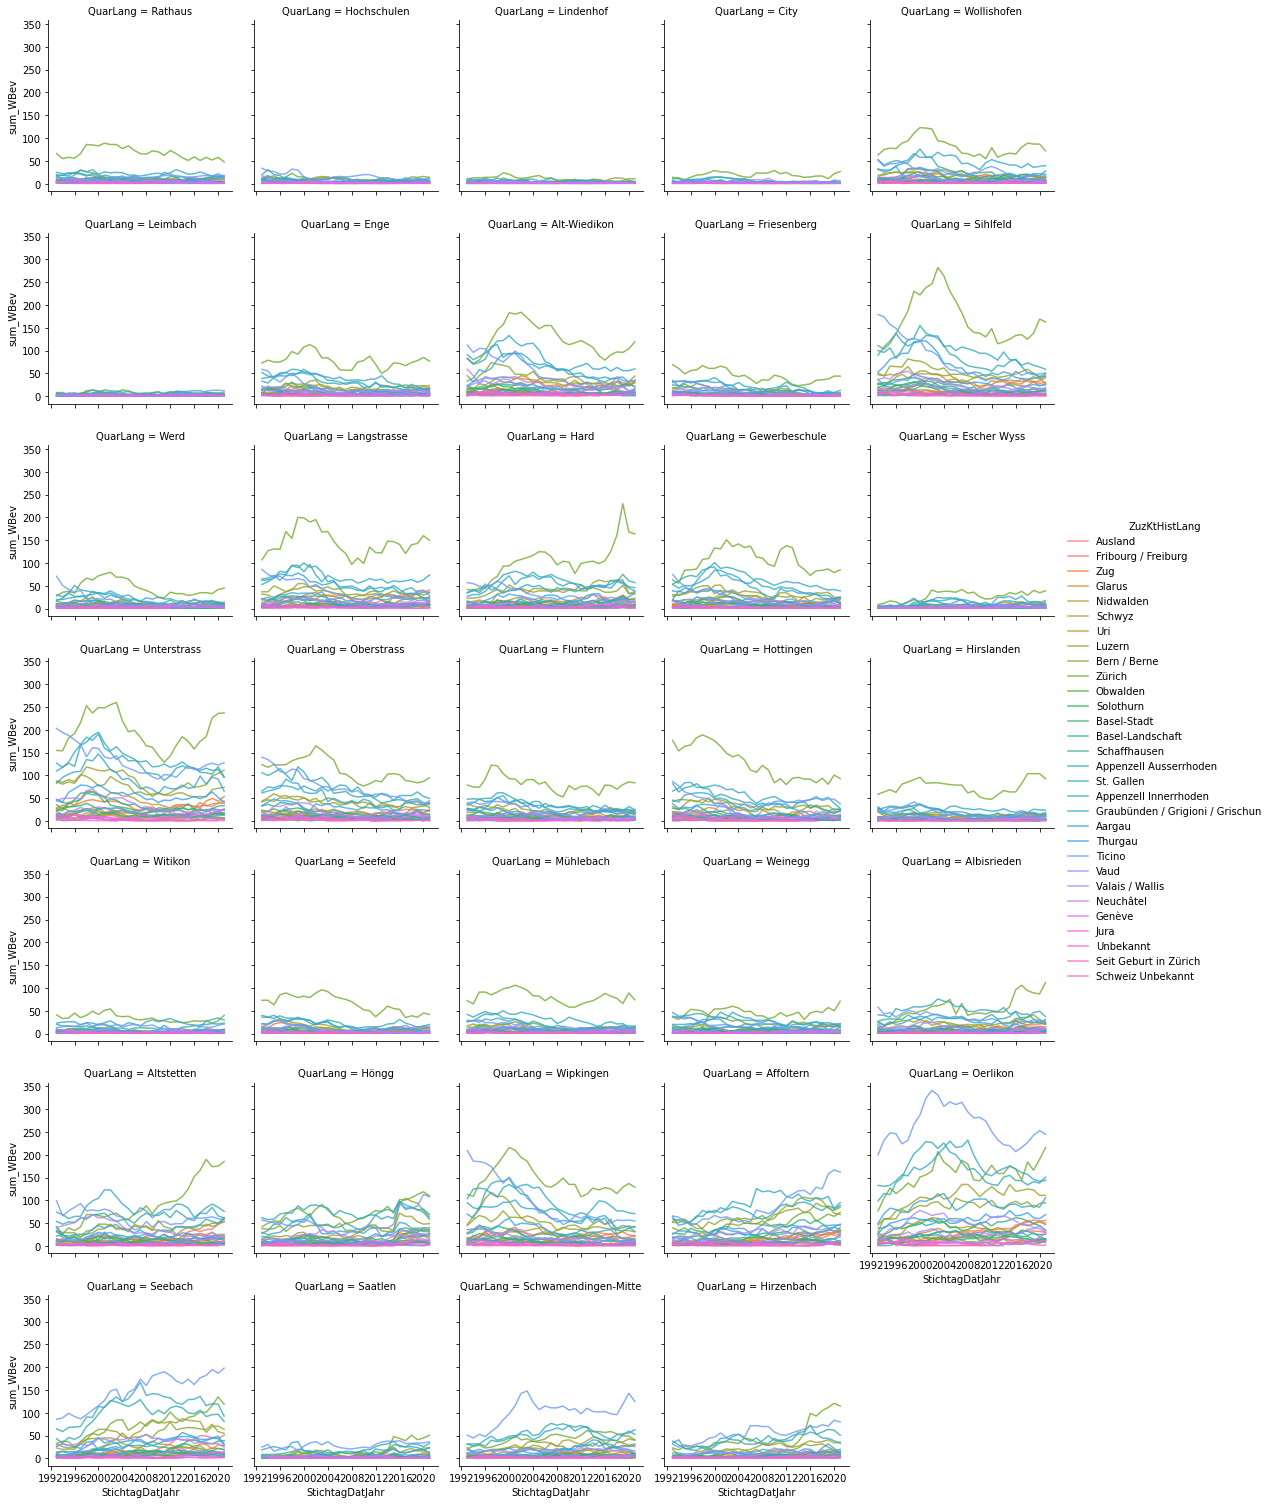

In [120]:
#g = sns.FacetGrid(myAggBar.reset_index(), col="QuarLang", hue="HerkunftLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "AlterV05Sort", "sum_WBev", alpha=.8)
#g.add_legend()

g2 = sns.FacetGrid(myAggBar.reset_index(), col="QuarLang", hue="ZuzKtHistLang", col_wrap=5, height=3 )
g2.map(sns.lineplot, "StichtagDatJahr","sum_WBev",alpha=.8)

g2.add_legend()


### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

In [123]:
myTreemapAgg = data2betested.loc["2021"].reset_index() \
    .groupby(['StichtagDatJahr', 'ZuzKtHistLang', 'ZuzBezirkHistLang']) \
    .agg(AnzBestWir=('AnzBestWir', 'sum')) \
    .sort_values('AnzBestWir', ascending=False) 

myTreemapAgg.reset_index().head(3)

,StichtagDatJahr,ZuzKtHistLang,ZuzBezirkHistLang,AnzBestWir
0,2021-01-01,Ticino,Distretto di Lugano,762
1,2021-01-01,Ausland,Ausland,724
2,2021-01-01,Zürich,Bezirk Meilen,585


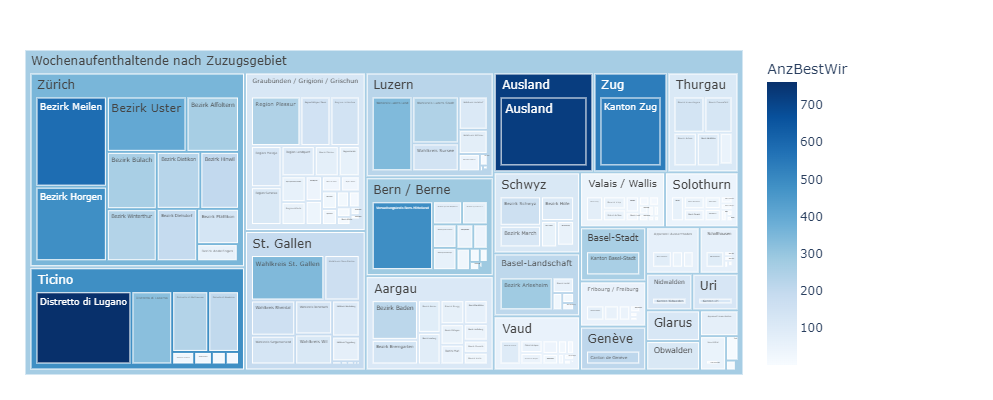

In [126]:
myTitle="Wochenaufenthaltende nach Zuzugsgebiet"

fig = px.treemap(myTreemapAgg.reset_index(), path=[px.Constant(myTitle), 'ZuzKtHistLang','ZuzBezirkHistLang']
                 , values='AnzBestWir'
                 , color='AnzBestWir'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=400
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [135]:
df = data2betested.loc["2021"].reset_index() \
    .groupby(['StichtagDatJahr', 'ZuzKtHistLang', 'ZuzBezirkHistLang', 'AlterV10Lang']) \
    .agg(AnzBestWir=('AnzBestWir', 'sum')) \
    .sort_values('AnzBestWir', ascending=False) 

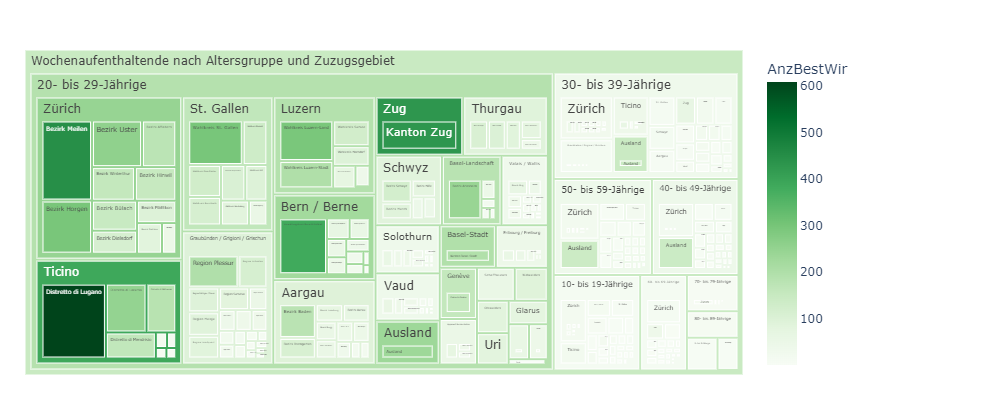

In [137]:
myTitle="Wochenaufenthaltende nach Altersgruppe und Zuzugsgebiet"

fig = px.treemap(df.reset_index(), path=[px.Constant(myTitle), 'AlterV10Lang', 'ZuzKtHistLang','ZuzBezirkHistLang']
                 , values='AnzBestWir'
                 , color='AnzBestWir'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Greens'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])           
                 ,height=400
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

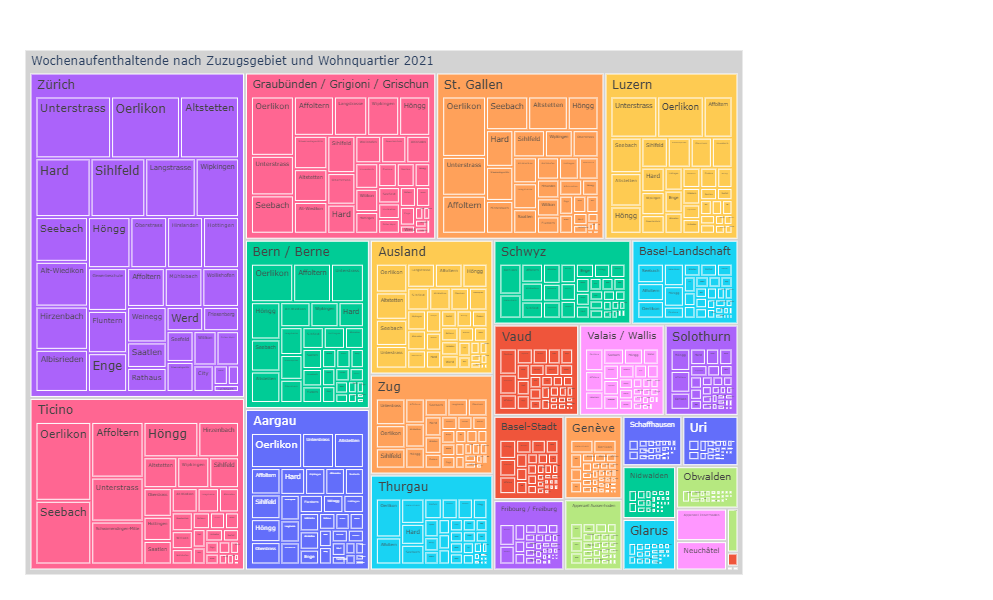

In [145]:
myTitle="Wochenaufenthaltende nach Zuzugsgebiet und Wohnquartier 2021"

df = data2betested.loc["2021"].reset_index() \

fig = px.treemap(df, path=[px.Constant(myTitle), 'ZuzKtHistLang', 'QuarLang']
                 , values='AnzBestWir'
                 , color='ZuzKtHistLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                #, color_continuous_scale='blues'
                 ,height=600
                 ,width=1200                          
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

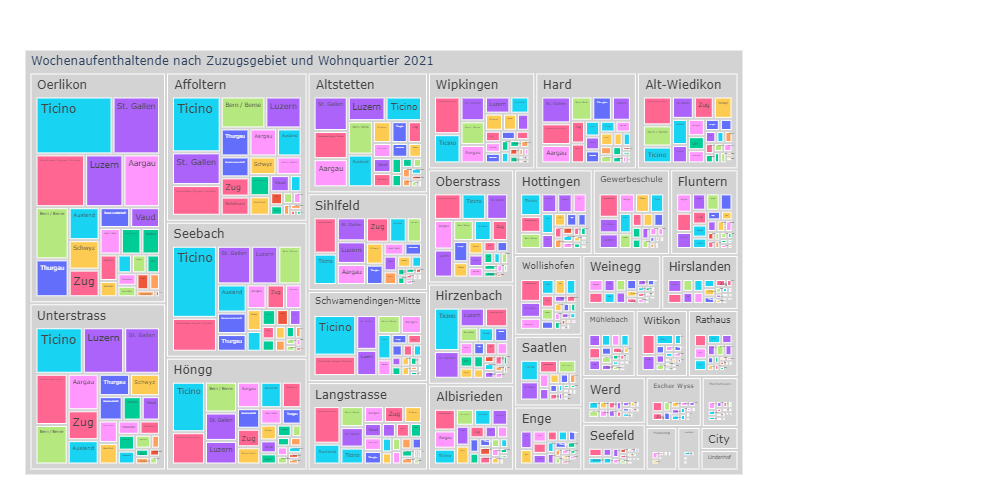

In [146]:
myTitle="Wochenaufenthaltende nach Zuzugsgebiet und Wohnquartier 2021"

df = data2betested.loc["2021"].query('ZuzKtHistLang != "Zürich"').reset_index() \

fig = px.treemap(df, path=[px.Constant(myTitle),'QuarLang','ZuzKtHistLang']
                 , values='AnzBestWir'
                 , color='ZuzKtHistLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                #, color_continuous_scale='blues'
                 ,height=500
                 ,width=1200                          
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [156]:
data2betested.columns

Index(['AlterV10Cd', 'AlterV10Lang', 'HerkunftCd', 'HerkunftLang', 'KreisCd', 'KreisLang',
       'QuarCd', 'QuarLang', 'ZuzKtHistCd', 'ZuzKtHistLang', 'ZuzBezirkHistCd',
       'ZuzBezirkHistLang', 'AnzBestWir', 'StichtagDatJahr_str'],
      dtype='object')

In [33]:
myAgg = data2betested.query('StichtagDatJahr !="1991"') \
    .groupby(['StichtagDatJahr', 'KreisLang', 'ZuzKtHistLang', 'AlterV10Cd' ]) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=False) 

myAgg.reset_index()

,StichtagDatJahr,KreisLang,ZuzKtHistLang,AlterV10Cd,sum_WBev
0,2021-01-01,Kreis 11,Ticino,20,516
1,2020-01-01,Kreis 11,Ticino,20,499
2,2019-01-01,Kreis 11,Ticino,20,497
3,2011-01-01,Kreis 11,Ticino,20,466
4,2012-01-01,Kreis 11,Ticino,20,459
...,...,...,...,...,...
39258,2003-01-01,Kreis 8,Ticino,50,1
39259,2014-01-01,Kreis 8,St. Gallen,60,1
39260,2003-01-01,Kreis 8,Thurgau,40,1
39261,2003-01-01,Kreis 8,Thurgau,10,1


## ---------------------- hier Plausi beendet

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=115&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------------------------------------------------------------